In [32]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
#np.random.seed(42)

In [2]:
# Edinburgh
from data_processing import read_edinburgh_data 
data, agent_ids = read_edinburgh_data()

/Users/kriis/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


reading:./OpenTraj/datasets/Edinburgh/annotations/tracks.01Sep.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2342/2342 [01:01<00:00, 38.27it/s]


Warning! too big dt in [Edinburgh]
finish


In [3]:
def agent_data(data, agent_id):
    x = data["pos_x"].loc[data["agent_id"]==agent_id].values
    y = data["pos_y"].loc[data["agent_id"]==agent_id].values

    max_train_idx = len(x)-10
    
    return x, y, max_train_idx

# Sample train and test data for pos_x and pos_y, each slice with num_steps length
def generate_data(data, begin_idx, agent_id, num_steps=5):
    sample_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values
    sample_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values

    test_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    test_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    
    return sample_x, sample_y, test_x, test_y
    
def calculate_FDE(pred_x, pred_y, test_x, test_y):

    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    return FDE

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

In [58]:
def average_angle(sample_vel_x, sample_vel_y):
    all_angles = []
    for i in range(1, len(sample_vel_x)):
        prev_vel = [sample_vel_x[i-1], sample_vel_y[i-1]]
        curr_vel = [sample_vel_x[i], sample_vel_y[i]]
        one_angle = np.math.atan2(np.linalg.det([prev_vel, curr_vel]),np.dot(prev_vel, curr_vel))   
        all_angles.append(one_angle)
    
    avg_angle = np.mean(all_angles)
    return avg_angle

def get_action():
    if np.random.rand() < 0.01:
        return 'STOP'
    
    if np.random.rand() < 0.8:
        return 'AVG_VEL'
    else:
        return 'AVG_VEL_W_ROTATION'

In [74]:
def predict(data, agent_id, start_idx, noise_var = 0.1):
    # read in the trajectory data
    sample_x, sample_y, test_x, test_y = generate_data(data, start_idx, agent_id, 5)
    
    # calculate velocity data
    sample_vel_x = [(sample_x[i] - sample_x[i-1]) + np.random.normal(0, noise_var) for i in range(1, len(sample_x))]
    sample_vel_y = [(sample_y[i] - sample_y[i-1]) + np.random.normal(0, noise_var) for i in range(1, len(sample_y))]
    
    avg_vel_x = np.mean(sample_vel_x)
    avg_vel_y = np.mean(sample_vel_y)
    
    avg_angle = average_angle(sample_vel_x, sample_vel_y)
    
    # start predictions
    pred_x = []
    pred_y = []
    
    for i in range(5):
        action = get_action()
        print(action)
        if action == 'AVG_VEL':
            if len(pred_x) == 0:
                pred_x.append(sample_x[-1] + avg_vel_x)
                pred_y.append(sample_y[-1] + avg_vel_y)
            else:
                pred_x.append(pred_x[-1] + avg_vel_x)
                pred_y.append(pred_y[-1] + avg_vel_y)
        elif action == 'AVG_VEL_W_ROTATION':
            if len(pred_x) == 0:
                prev_x = sample_x[-2]
                prev_y = sample_y[-2]
                cur_x = sample_x[-1] + avg_vel_x
                cur_y = sample_y[-1] + avg_vel_y
            else:
                prev_x = pred_x[-1]
                prev_y = pred_y[-1]
                cur_x = pred_x[-1] + avg_vel_x
                cur_y = pred_y[-1] + avg_vel_y
            rot_x, rot_y = rotate((prev_x, prev_y), (cur_x, cur_y), 5) # maybe avg_angle needs to be multiplied by step number?
            pred_x.append(rot_x)
            pred_y.append(rot_y)
            
            avg_vel_x = rot_x - prev_x
            avg_vel_y = rot_y - prev_y
        elif action == 'STOP':
            if len(pred_x) == 0:
                pred_x.append(sample_x[-1])
                pred_y.append(sample_y[-1])
            else:
                pred_x.append(pred_x[-1])
                pred_y.append(pred_y[-1])
        
    return pred_x, pred_y
            

AVG_VEL_W_ROTATION
AVG_VEL
AVG_VEL
AVG_VEL_W_ROTATION
AVG_VEL


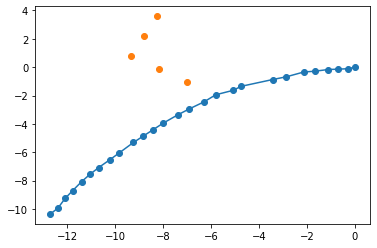

In [80]:
for agent_id in agent_ids[:1]:
    x_data, y_data, max_train_idx = agent_data(data, agent_id)
    random_start_idx = np.random.randint(0, max_train_idx)
    
    pred_x, pred_y = predict(data, agent_id, random_start_idx)
    plt.plot(x_data, y_data)
    plt.scatter(x_data, y_data)
    plt.scatter(pred_x, pred_y)